In [1]:
import os
import glob
import math
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import clima_anom as ca
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%run ../function/function.ipynb

In [2]:
# so = 'manjaro'
so = 'xubuntu'

In [3]:
if so == 'xubuntu':
    base = '/media/'
elif so == 'manjaro':
    base = '/run/media/'
print(f'so  : {so}')
print(f'base: {base}')

so  : xubuntu
base: /media/


In [4]:
shape = list(shpreader.Reader('../mappings/SaoPaulo_Fixed.shp').geometries())

In [7]:
Brasildat_dir = base + 'arturo/Arturo/Data/BrasilDat/Campinas/2018/grid/BrasilDat_2018_03_5min_8kmx8km.nc'
Brasildat = ca.read_netcdf(Brasildat_dir,2)
lat = Brasildat['lat']
lon = Brasildat['lon']
time_B = Brasildat['time']
flash_B = Brasildat['flash']

lon2d, lat2d = np.meshgrid(lon,lat)
nt, ny, nx = np.shape(flash_B)

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


In [8]:
GLM_dir = base + 'arturo/Arturo/Data/GLM/Campinas/2018/grid/GLM_2018_03_5min_8kmx8km.nc'
GLM = ca.read_netcdf(GLM_dir,2)
flash_G = GLM['flash']

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


## Cleaning data

In [9]:
lat_c = -22.8611
lon_c = -47.0563
r = (180)/111

In [10]:
Area_R = np.zeros([ny,nx])
for i in range(ny):
    for j in range(nx):
        Dist = distancia(lat_c,lon_c,lat[i],lon[j])
        if Dist <= 162:
            Area_R[i,j] = 1

In [11]:
G_new = np.zeros([nt,ny,nx])
B_new = np.zeros([nt,ny,nx])
for t in range(nt):
    for i in range(ny):
        for j in range(nx):
            if Area_R[i,j] == 1:
                G_new[t,i,j] = flash_G[t,i,j]
                B_new[t,i,j] = flash_B[t,i,j]
            else:
                G_new[t,i,j] = np.nan
                B_new[t,i,j] = np.nan

In [12]:
BrD = np.nanmean(B_new,axis=0)
GLM = np.nanmean(G_new,axis=0)

/tmp/ipykernel_122436/1482207350.py:1: RuntimeWarning: Mean of empty slice
  BrD = np.nanmean(B_new,axis=0)
/tmp/ipykernel_122436/1482207350.py:2: RuntimeWarning: Mean of empty slice
  GLM = np.nanmean(G_new,axis=0)


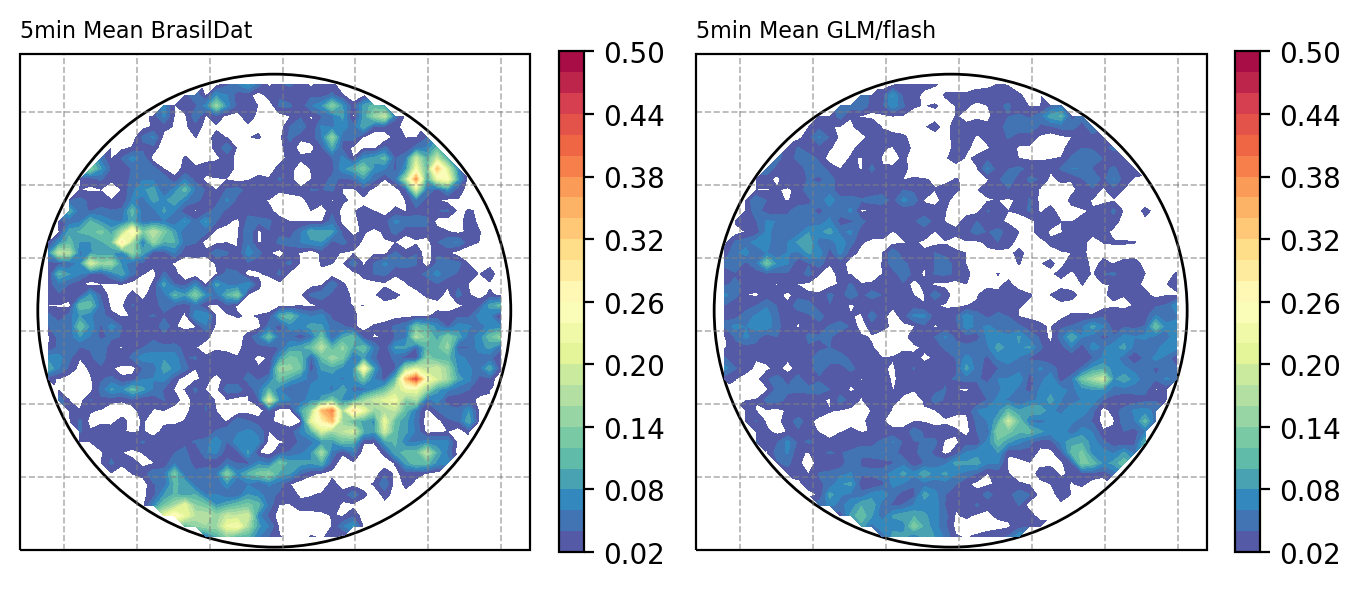

In [21]:
levels = np.arange(0.02,0.52,0.02)

circle1 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)

fig = plt.figure(figsize=(8,4),dpi=200)
proj = ccrs.PlateCarree()
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj) 
ax1.add_artist(circle1)
a1 = plt.contourf(lon2d,lat2d,BrD,levels=levels,cmap=plt.cm.Spectral_r)
# ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.set_title('5min Mean BrasilDat', loc='left', fontsize=8)
plt.colorbar(a1,fraction=0.0444)

#==================================================================================================
ax2 = plt.subplot(gs[0, 1], projection = proj) 
ax2.add_artist(circle2)
a2 = plt.contourf(lon2d,lat2d,GLM,levels=levels,cmap=plt.cm.Spectral_r)
# ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax2.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax2.set_title('5min Mean GLM/flash', loc='left', fontsize=8)
plt.colorbar(a2,fraction=0.0444)

salida = '../images/Mean_Brasildat_GLM_5min.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [22]:
ntime = int(nt/3)
print(ntime)
flash_B_15 = np.zeros([ntime, ny, nx])
flash_G_15 = np.zeros([ntime, ny, nx])
for t in range(ntime):
    # print(t,3*t,3*t+3)
    flash_B_15[t,:,:] = np.nansum(B_new[3*t:3*t+3,:,:],axis=0)
    flash_G_15[t,:,:] = np.nansum(G_new[3*t:3*t+3,:,:],axis=0)

2976


In [25]:
BrD = np.nanmean(flash_B_15,axis=0)
GLM = np.nanmean(flash_G_15,axis=0)

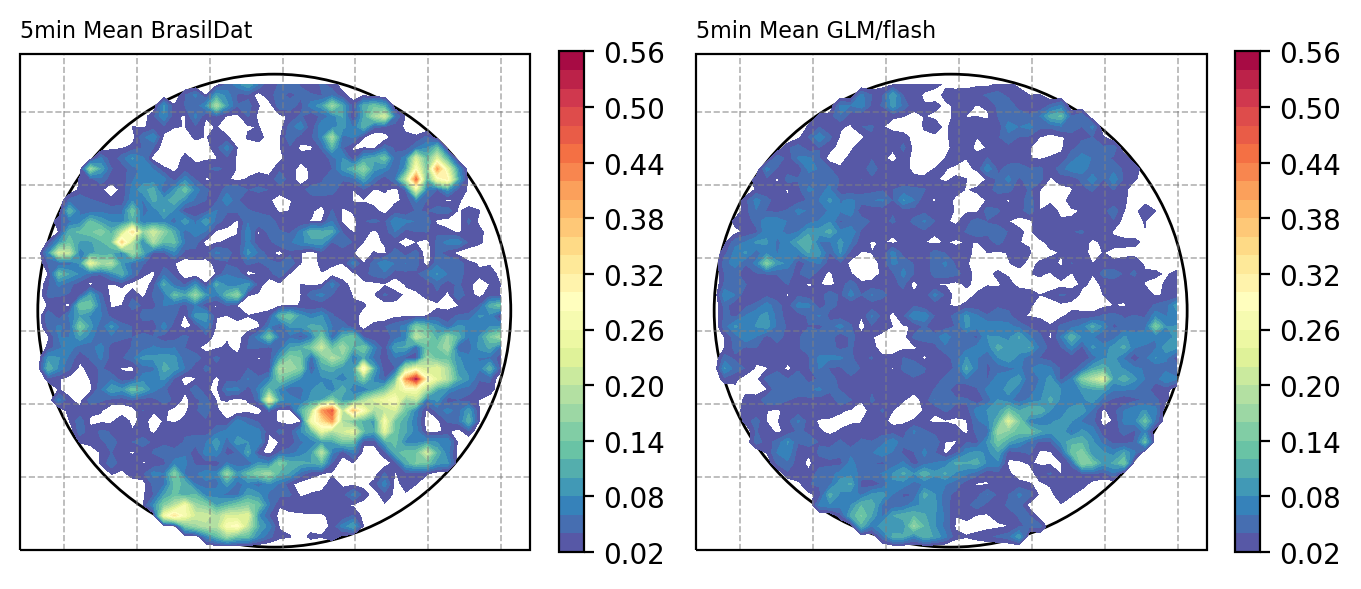

In [28]:
levels = np.arange(0.02,0.58,0.02)

circle1 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='k',fill=False)

fig = plt.figure(figsize=(8,4),dpi=200)
proj = ccrs.PlateCarree()
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj) 
ax1.add_artist(circle1)
a1 = plt.contourf(lon2d,lat2d,BrD,levels=levels,cmap=plt.cm.Spectral_r)
# ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.set_title('5min Mean BrasilDat', loc='left', fontsize=8)
plt.colorbar(a1,fraction=0.0444)

#==================================================================================================
ax2 = plt.subplot(gs[0, 1], projection = proj) 
ax2.add_artist(circle2)
a2 = plt.contourf(lon2d,lat2d,GLM,levels=levels,cmap=plt.cm.Spectral_r)
# ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax2.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax2.set_title('5min Mean GLM/flash', loc='left', fontsize=8)
plt.colorbar(a2,fraction=0.0444)

salida = '../images/Mean_Brasildat_GLM_15min.png'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## BrasilDat Export netcdf

In [41]:
print(f'Brasildat shape: {flash_B_15.shape}')
info = {'file': base + 'arturo/Arturo/Data/BrasilDat/Campinas/2018/grid/BrasilDat_2018_03_15min_8kmx8km.nc', # filename and directory
        'title': 'Brasildat data 8km x 8km', # netcdf title
        'year_start':2018,'month_start':3,'day_start':1,'hour_start':0,'minute_start':0, # time start (year,month,day,hour,minute)
        'year_end':2018,'month_end':3,'day_end':31,'hour_end':23,'minute_end':59, # time end (year,month,day,hour,minute)
        'time_frequency': 'Minutely', # options: Monthly, Daily, Hourly, Minutely
        'time_interval':15,
        'var_name': 'flash', # variable short name
        'var_units': 'flash/196km2'} # variable units

Brasildat shape: (2976, 45, 45)


In [42]:
ca.create_netcdf(info,flash_B_15,lat,lon)

Time Start: 2018-03-01 00:00:00
Time End: 2018-03-31 23:45:00
Time Frequency: Minutely
Time Lenght: 2976

File created in:  /media/arturo/Arturo/Data/BrasilDat/Campinas/2018/grid/BrasilDat_2018_03_15min_8kmx8km.nc
File title:  Brasildat data 8km x 8km
var title:  flash
var units:  flash/196km2


## GLM Export netcdf

In [23]:
print(f'Brasildat shape: {flash_G_15.shape}')
info = {'file': base + 'arturo/Arturo/Data/GLM/Campinas/2018/grid/GLM_2018_03_15min_8kmx8km.nc', # filename and directory
        'title': 'GLM-flash data 8km x 8km', # netcdf title
        'year_start':2018,'month_start':3,'day_start':1,'hour_start':0,'minute_start':0, # time start (year,month,day,hour,minute)
        'year_end':2018,'month_end':3,'day_end':31,'hour_end':23,'minute_end':59, # time end (year,month,day,hour,minute)
        'time_frequency': 'Minutely', # options: Monthly, Daily, Hourly, Minutely
        'time_interval':15,
        'var_name': 'flash', # variable short name
        'var_units': 'flash/196km2'} # variable units

Brasildat shape: (2976, 45, 45)


In [24]:
ca.create_netcdf(info,flash_G_15,lat,lon)

Time Start: 2018-03-01 00:00:00
Time End: 2018-03-31 23:45:00
Time Frequency: Minutely
Time Lenght: 2976

File created in:  /media/arturo/Arturo/Data/GLM/Campinas/2018/grid/GLM_2018_03_15min_8kmx8km.nc
File title:  GLM-flash data 8km x 8km
var title:  flash
var units:  flash/196km2
